In [1]:
asdasimport pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

from sklearn.metrics.cluster import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

import STAGATE_pyG

datadir = '/data1/shahs3/users/mezallj1/data/osmfish'
# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
#os.environ['R_HOME'] ='/home/mezallj1/miniconda3/envs/stagate_copy/lib/R'

In [2]:
adata = sc.read_h5ad(f'{datadir}/osmfish_remove_excluded.h5ad')
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [3]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

------Calculating spatial graph...
The graph contains 2180 edges, 4839 cells.
0.4505 neighbors per cell on average.


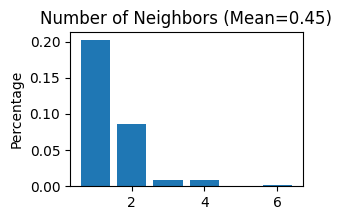

In [4]:
#Constructing the spatial network
STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE_pyG.Stats_Spatial_Net(adata)

In [5]:
#Running STAGATE
adata = STAGATE_pyG.train_STAGATE(adata)

Size of Input:  (4839, 33)


100%|██████████| 1000/1000 [00:51<00:00, 19.45it/s]


In [6]:
def mclust_P(adata, num_cluster, used_obsm='STAGATE', modelNames='EEE'):
     from sklearn import mixture
     np.random.seed(2020)
     g = mixture.GaussianMixture(n_components=num_cluster, covariance_type='diag')
     res = g.fit_predict(adata.obsm[used_obsm])
     adata.obs['mclust'] = res
     return adata

In [7]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
#adata = STAGATE_pyG.mclust_R(adata, used_obsm='STAGATE', num_cluster=11)
adata = mclust_P(adata, used_obsm='STAGATE', num_cluster=11)

In [8]:
obs_df = adata.obs.dropna()

In [9]:
ari = adjusted_rand_score(obs_df['Region'], obs_df['mclust'])
print(ari)

0.14818247246582758


In [10]:
adata.write(f'{datadir}/osmfish_stagate.h5ad')
#adata = sc.read(f'{datadir}/osmfish_stagate.h5ad')

# R mclust Function

In [8]:
import scanpy as sc
import numpy as np
import os

from sklearn.metrics.cluster import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

datadir = '/data1/shahs3/users/mezallj1/data/osmfish'
# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] ='/home/mezallj1/miniconda3/envs/r_env/lib/R'

In [4]:
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

In [10]:
adata = mclust_R(adata, used_obsm='STAGATE', num_cluster=11)

fitting ...
  |======================================================================| 100%


In [11]:
obs_df = adata.obs.dropna()

In [12]:
ari = adjusted_rand_score(obs_df['Region'], obs_df['mclust'])
print(ari)

0.09531600741934265
